In [1]:
import os
import torch
import numpy as np
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import joblib
from IPython.display import display
from PIL import Image
import time

In [2]:
MODEL_PATH = "Models/face_recognition2.pkl"

In [3]:
# Load face detection and embedding models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtcnn = MTCNN(image_size=160, margin=20, device=device)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

In [4]:
# Load trained classifier
data = joblib.load(MODEL_PATH)
clf = data["classifier"]
encoder = data["encoder"]

In [14]:
def capture_face():
    
    cap = cv2.VideoCapture(0)  # Open webcam
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    start_time = time.time()
    captured_face = None

    while time.time() - start_time < 10:  # Run for 10 seconds
        
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break
        
        # Convert to RGB format for MTCNN
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)

        # Detect faces
        boxes, _ = mtcnn.detect(img_pil)

        if boxes is not None:
            for box in boxes:
                x1, y1, x2, y2 = map(int, box)

                # Crop the first detected face
                captured_face = img_rgb[y1:y2, x1:x2]

                # Show the detected face
                display(Image.fromarray(captured_face))

                cap.release()
                cv2.destroyAllWindows()
                return captured_face  # Return the cropped face

        cv2.imshow("Webcam - Detecting Face", frame)
        if cv2.waitKey(1) & 0xFF == 27:  # Press ESC to exit
            break

    
    cap.release()
    cv2.destroyAllWindows()
    print("No face detected within 10 seconds.")
    return None

In [15]:
def recognize_face(face_image):
    print("Hello")
    if face_image is None:
        print("No face to recognize!")
        return
    
    # Resize face for FaceNet
    face = cv2.resize(face_image, (160, 160))
    print("Face resized")
    
    # Convert to tensor
    face = torch.tensor(face).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    face = face.to(device)

    # Extract embedding
    embedding = resnet(face).detach().cpu().numpy().flatten()

    # Predict identity
    probs = clf.predict_proba([embedding])[0]
    max_prob = max(probs)
    predicted_label = encoder.inverse_transform([np.argmax(probs)])[0]

    # Display result
    person_name = predicted_label if max_prob > 0.6 else "Unknown"
    print(f"Recognized Person: {person_name} ({max_prob:.2f})")


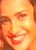

In [21]:
face = capture_face()  # Step 1: Capture face
#    # Step 2: Recognize face

In [22]:
recognize_face(face)

Hello
Face resized
Recognized Person: Aisha (0.77)
